In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 692.3 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = np.load('/content/drive/MyDrive/dml/indian-veriseti/indianpinearray.npy')

gt = np.load('/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy')


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


data=applyPCA(data)


df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values



Mounted at /content/drive


In [4]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import NCA



acc_list = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

nca = NCA(max_iter=100,verbose=True)
knn = KNeighborsClassifier(n_neighbors=5)

fold_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {fold_index} -> Train: {len(train_index)}, Test: {len(test_index)}")


    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    nca.fit(X_train, y_train)
    knn.fit(nca.transform(X_train), y_train)


    nca_acc = knn.score(nca.transform(X_test), y_test)
    print('nca accuracy {}'.format( nca_acc))

    acc_list.append(nca_acc)

    fold_index += 1

Fold 1 -> Train: 8199, Test: 2050
Finding most discriminative components... 
done in  0.01s
[NCA]
[NCA]  Iteration      Objective Value    Time(s)
[NCA] ------------------------------------------
[NCA]          0         5.455045e+03       3.01
[NCA]          1         5.830721e+03       2.92
[NCA]          2         6.349049e+03       3.01
[NCA]          3         6.546811e+03       3.06
[NCA]          4         6.704768e+03       3.67
[NCA]          5         6.791649e+03       4.23
[NCA]          6         6.855363e+03       4.55
[NCA]          7         6.873757e+03       4.59
[NCA]          8         6.908118e+03       4.57
[NCA]          9         6.927370e+03       4.61
[NCA]         10         6.948532e+03       4.54
[NCA]         11         6.958196e+03       4.58
[NCA]         12         6.978035e+03       4.67
[NCA]         13         6.989250e+03       4.56
[NCA]         14         7.003193e+03       4.51
[NCA]         15         7.016573e+03       4.56
[NCA]         16    

In [5]:
import joblib

joblib.dump(nca, 'nca_indian_model.pkl')
joblib.dump(knn,'nca_indian_knn_model.pkl')

nca_loaded = joblib.load('nca_indian_model.pkl')
knn_loaded =joblib.load('nca_indian_knn_model.pkl')

nca_data=nca_loaded.transform(X)
pred=knn_loaded.predict(nca_data)

In [6]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

accuracy: 0.8843789638013465
cohen kappa: 0.8680479873384112
f1 score: 0.8720651414302231


In [7]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

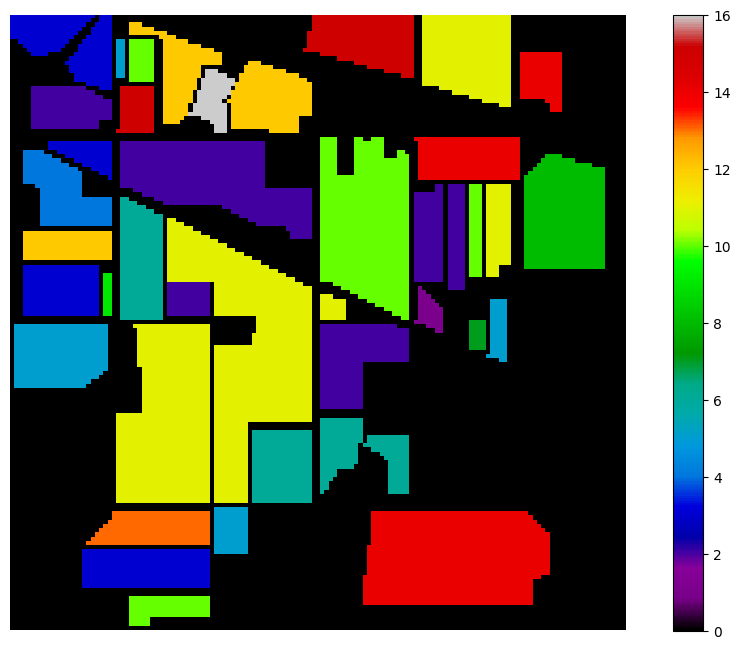

In [8]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

In [13]:
gt_2=gt_2.reshape(145,-1)

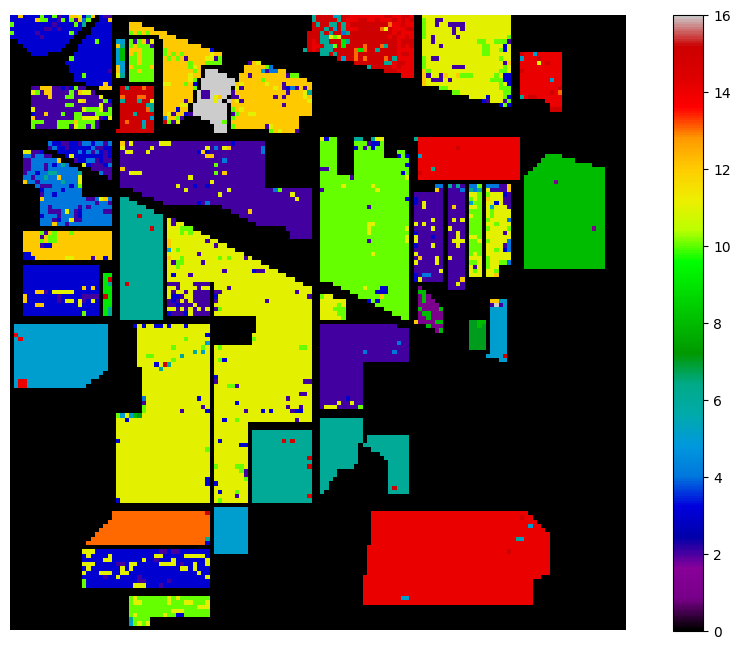

In [14]:
plot_gt(gt_2)